<a href="https://colab.research.google.com/github/netgvarun2021/Blackbox/blob/main/TextifyProofReading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [296]:
import os
import pandas as pd
import spacy
from spacy import displacy
import nltk
from nltk.tokenize import word_tokenize
from google.colab import drive
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textatistic import Textatistic
from spacy.matcher import Matcher
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [297]:
imdb_dir = '/content/gdrive/MyDrive'
dataset_dir = os.path.join(imdb_dir, 'Textify.ai/Textify AI Text Corpus Center (Responses).xlsx')
#dataset_dir = os.path.join(imdb_dir, 'Textify.ai/training_set_rel3.xls')
#print(dataset_dir)
bad_essays = os.path.join(imdb_dir,'Textify.ai/First Draft Essays.xlsx')

In [298]:
df = pd.read_excel(dataset_dir)
df_bad = pd.read_excel(bad_essays)

In [299]:
df.shape,df_bad.shape

((734, 11), (302, 2))

In [300]:
df.head()

,Timestamp,Contributor,Topic,Writing Style,Essay Text,Essay Grading,University Name,Education Program,Relevant Field (Major/ Subject of study etc),Reference Link,Comments (is something unusual about the essay?)
0,2021-06-20 05:36:05.410,Tin,Bacon,Narrative,"THE ALARM CLOCK IS, TO MANY high school studen...",Average (B-C),Duke University,Bachelors,NaN,http://www.qianmu.org/u/lystu/school/file/0hme...,NaN
1,2021-06-20 05:47:07.236,Tin,“Beyond Plug-and-Chug Math”,Persuasive,I HAVE ALWAYS BEEN A MATH-SCIENCE girl. I sigh...,Average (B-C),MIT - Massachusetts Institute of Technology,Bachelors,Mathematics,http://www.qianmu.org/u/lystu/school/file/0hme...,NaN
2,2021-06-20 06:00:53.430,Tin,“A Different Kind of love”,"Narrative, Personal","WHEN I WAS FOUR YEARS OLD, I fell in love. It ...",Excellent (A+),Stanford University,Bachelors,Spanish Language,http://www.qianmu.org/u/lystu/school/file/0hme...,NaN
3,2021-06-20 06:12:52.684,Tin,“From Flaubert to Frisbee”,Persuasive,"THIS SUMMER, I WENT TO THE governor’s Honors P...",Average (B-C),Brown University,Masters,Literature,http://www.qianmu.org/u/lystu/school/file/0hme...,NaN
4,2021-06-20 06:20:05.473,Tin,Raising the Bar,Narrative,THIS PAST SUMMER I HAD THE opportunity to part...,Average (B-C),NaN,Masters,Engineering and Sciences,http://www.qianmu.org/u/lystu/school/file/0hme...,NaN


In [301]:
df_bad.head()

,Essay_Text,Grade
0,"As I receive my diploma on graduation day, I'd...",Bad (D-F)
1,Cornell University School of Hotel Administrat...,Bad (D-F)
2,"One thing that you do not know about me, is th...",Bad (D-F)
3,"""Don't Think""\n I was dancing the salsa, dress...",Bad (D-F)
4,"""Loading... Loading... Loading..."", I stared i...",Bad (D-F)


In [302]:
nlp = spacy.load('en_core_web_sm')

In [303]:
#df_essays_recovery = df_essays.copy()
df_initial = df[['Essay Text','Essay Grading']]
df_initial['Essay Grading'].value_counts()

Average (B-C)     401
Excellent (A+)    288
Bad (D-F)          45
Name: Essay Grading, dtype: int64

In [304]:
df_bad.rename(columns={'Essay_Text':'Essay Text','Grade':'Essay Grading'},inplace=True)

In [305]:
df_essays = pd.concat([df_initial,df_bad])

In [306]:
df_essays.head()

,Essay Text,Essay Grading
0,"THE ALARM CLOCK IS, TO MANY high school studen...",Average (B-C)
1,I HAVE ALWAYS BEEN A MATH-SCIENCE girl. I sigh...,Average (B-C)
2,"WHEN I WAS FOUR YEARS OLD, I fell in love. It ...",Excellent (A+)
3,"THIS SUMMER, I WENT TO THE governor’s Honors P...",Average (B-C)
4,THIS PAST SUMMER I HAD THE opportunity to part...,Average (B-C)


In [307]:
df_essays['Essay Grading'].value_counts()

Average (B-C)     401
Bad (D-F)         347
Excellent (A+)    288
Name: Essay Grading, dtype: int64

# **FEATURE EXTRACTION FROM ESSAY'S ASCII TEST**

## **COUNTING SENTENCES**

In [308]:
def count_sentences(essay):
  doc = nlp(essay)
  doc_sents = [sent for sent in doc.sents]
  return len(doc_sents)


In [309]:
str = '“I wanna go home!” I say as I sit on the kitchen floor watching my mother cook. “What do you mean?” she asks, giving me a questioning look. “Ethiopia?” “I don’t know.” Home. For most people, the word can be easily defined as the place where they grew up or live now. By that definition, the house in which I have lived for the past seven years would be my home. The problem is, I often find myself saying, “I wanna go home,” while sitting in that very house. The other candidate is the place where I grew up, but that could be either of two places: my home country of Ethiopia or my adopted hometown of Westbrook, Maine. I cannot choose one over the other. For better or for worse, each has shaped the person I am today more than can be expressed in words. Ethiopia is the place where I experienced so many of my “firsts.” Maine is the place where I developed my individuality. At the same time, neither can truly be my home. Though Ethiopia was my home at one point, it is no longer the same place I knew as a child because I am no longer that child. I can no longer relate to the culture the way I once did. As my sister often tells me, I have become “Americanized.” On the other hand, I have never felt at home in Maine. The first memory I have of Maine is my first day visiting Reiche Elementary, the school I would be attending. I stood in front of a group of seven- and eight-year-old boys and girls. Every face was pointed at me, every pair of eyes wide and expectant. I grabbed the fabric of my mother’s skirt and buried my face into the side of her leg. These children were all so different. Every child had a skin color different from mine. Though I picked out a few familiar words, I could not understand what they were saying. I knew I didn’t belong there, but there was no chance of hopping on a plane and going back to Ethiopia. I knew that, and the thought terrified me. I had never felt as uncomfortable and uncertain as I did that day. That day has stayed with me, along with the discomfort and uncertainty. Though the intensity of those feelings has faded, it has not gone away, and it is not likely to leave me soon. I cannot deny, however, that the environment Maine has provided has shaped me profoundly. Living in Maine has made me who I am today just as much as being born and raised in Ethiopia. Ethiopia gave me my cultural and family identity. Ethiopia is the place that comes to mind when I think of my family, since my entire extended family remains there. It is also the place that comes to mind when I think of my motivation, since I was raised in a culture that taught me to give one hundred percent at all times. Yet, the fact remains that I have lived in Maine for nearly ten years of my life. This environment has influenced me more than even I can comprehend. So, the question becomes: which of these places (if either) should I consider my home? In all honesty, I cannot choose one physical place and give it the title of “home.” Instead, I elect to compose my own definition of home, a definition that does not force me to choose between the two places in which I grew up. My definition allows me to think of home as a place in my mind, a state of mind that enables me to remember my childhood years in Ethiopia and the opportunities given to me by living in the U.S. It has taken a long time to define what home means to me — and even longer to find it — but doing so has given me an amazing sense of hope and comfort. In my mind, it is a place where I can escape. It is a place from which I draw strength when life gets too hectic or when I am faced with challenges that seem too great to overcome. It is what I really mean — what I have always meant — when I say that I want to go home.'
count_sentences(str)

48

In [310]:
df_essays['SentenceCount'] = df_essays['Essay Text'].apply(count_sentences)

In [311]:
df_essays[:10]

,Essay Text,Essay Grading,SentenceCount
0,"THE ALARM CLOCK IS, TO MANY high school studen...",Average (B-C),35
1,I HAVE ALWAYS BEEN A MATH-SCIENCE girl. I sigh...,Average (B-C),28
2,"WHEN I WAS FOUR YEARS OLD, I fell in love. It ...",Excellent (A+),40
3,"THIS SUMMER, I WENT TO THE governor’s Honors P...",Average (B-C),20
4,THIS PAST SUMMER I HAD THE opportunity to part...,Average (B-C),23
5,"My eyes widen. “It’s all Greek to me,” I whisp...",Excellent (A+),46
6,"I could still hear her words, the words my tea...",Average (B-C),31
7,It was a wet and dreary October evening. I sho...,Average (B-C),30
8,"Oreos. On the exterior, a firm chocolate crust...",Average (B-C),43
9,"Whether I was blowing out candles, writing a l...",Average (B-C),21


In [312]:
df_essays.iloc[700].values[0]

'“Jooooorrrrddddannnnn,” my mom screamed with utter fear and panic in her voice. Surprisingly, amongst all of the chaos, her voice was all that I heard. I’m not sure if I was disoriented, bewildered or just in complete shock but at that particular moment, I felt nothing. That feeling of nothingness lasted 2.5 seconds because then the excruciating pain began. My knee felt as if someone had hit me with a Mack truck going 90 miles per hour. For the first time in my life, I had experienced real pain. I was 10 years old and I shattered my knee.\nI have always been a well rounded student. My focus has always been on my school and everything that comes along with it, which included extra-curricular activities. I was an avid gymnast. I had been in gymnastics since I was 3 years old. My parents were both extremely athletic. My dad was an All-American college football player and my mom was a cheerleader, so it was only fitting that I participated in something athletically strenuous as well. They

## **COUNTING WORDS w/o STOP WORDS**

In [208]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [313]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [314]:
word_tokens = word_tokenize(df_essays.iloc[729].values[0])
stop_words = set(stopwords.words('english'))

In [315]:
# def count_non_stop_words(essay):
#   word_tokens = word_tokenize(essay)
#   filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
#   return len(filtered_sentence)
def count_non_stop_words(essay):
  word_tokens = word_tokenize(essay)
  filtered_sentence = [w for w in word_tokens]
  return len(filtered_sentence)


In [316]:
df_essays['WordCount'] = df_essays['Essay Text'].apply(count_non_stop_words)

In [317]:
df_essays.head()

,Essay Text,Essay Grading,SentenceCount,WordCount
0,"THE ALARM CLOCK IS, TO MANY high school studen...",Average (B-C),35,798
1,I HAVE ALWAYS BEEN A MATH-SCIENCE girl. I sigh...,Average (B-C),28,588
2,"WHEN I WAS FOUR YEARS OLD, I fell in love. It ...",Excellent (A+),40,994
3,"THIS SUMMER, I WENT TO THE governor’s Honors P...",Average (B-C),20,560
4,THIS PAST SUMMER I HAD THE opportunity to part...,Average (B-C),23,544


In [214]:
#df_essays_mini = df_essays[:1]

## **COUNTING PARTS OF SPEECH**

In [318]:
def count_feature(postag,essay,wordcount,roundval):
  doc=nlp(essay)
  pos_counts = doc.count_by(spacy.attrs.POS)
  for k,v in sorted(pos_counts.items()):
    if doc.vocab[k] == postag:
      return round(v/wordcount,roundval)

# def count_verb(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'VERB':
#       return round(v/wordcount,0)

# def count_noun(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'NOUN':
#       return round(v/wordcount,0)

# def count_adjective(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'ADJ':
#       return round(v/wordcount,0)

# def count_adverb(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'ADV':
#       return round(v/wordcount,0)    

# def count_pronoun(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'PRON':
#       return round(v/wordcount,0)

# def count_punctuations(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'PUNCT':
#       return round(v/wordcount,0)                        

In [319]:
df_essays['VerbCount']  = df_essays.apply(lambda x: count_feature('VERB',x['Essay Text'], 1,0), axis=1)
df_essays['NounCount']  = df_essays.apply(lambda x: count_feature('NOUN',x['Essay Text'], 1,0), axis=1)
df_essays['AdjCount']  = df_essays.apply(lambda x: count_feature('ADJ',x['Essay Text'], 1,0), axis=1)
df_essays['AdverbCount']  = df_essays.apply(lambda x: count_feature('ADV',x['Essay Text'], 1,0), axis=1)
df_essays['PronounCount']  = df_essays.apply(lambda x: count_feature('PRON',x['Essay Text'], 1,0), axis=1)
df_essays['PunctCount']  = df_essays.apply(lambda x: count_feature('PUNCT',x['Essay Text'], 1,0), axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8533111450>,
      dtype=object)

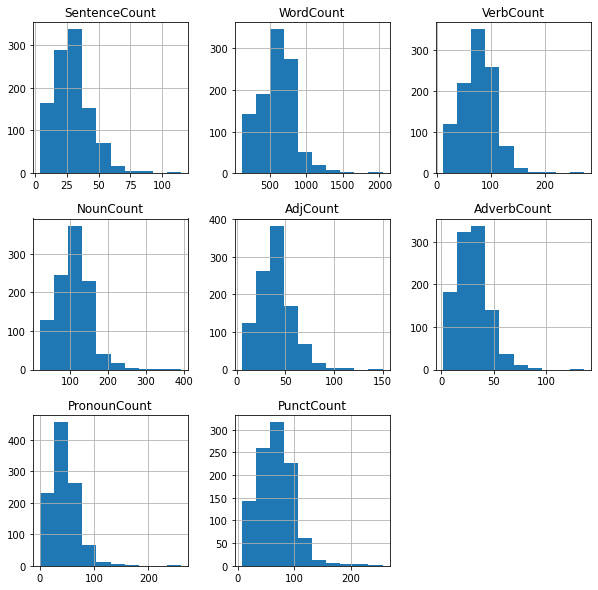

In [320]:
df_essays.hist(figsize=(10,10))

# Day 2

# **Normalizing the grades distribution by Feature Counts**

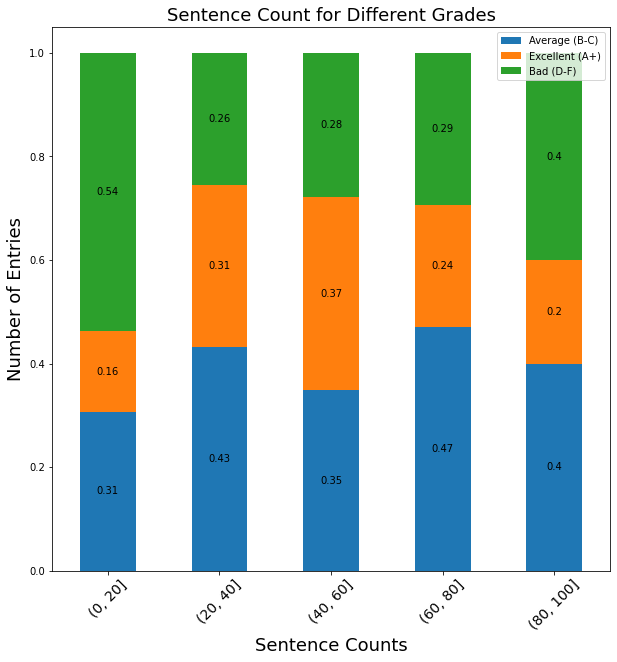

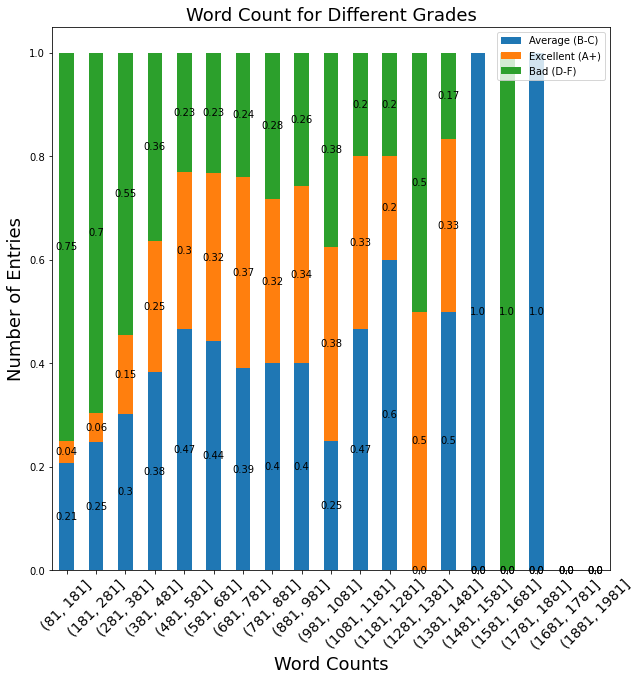

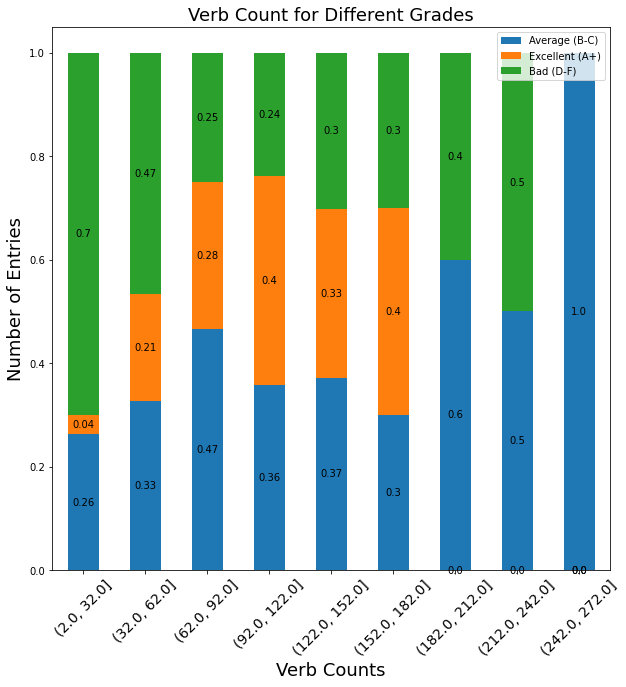

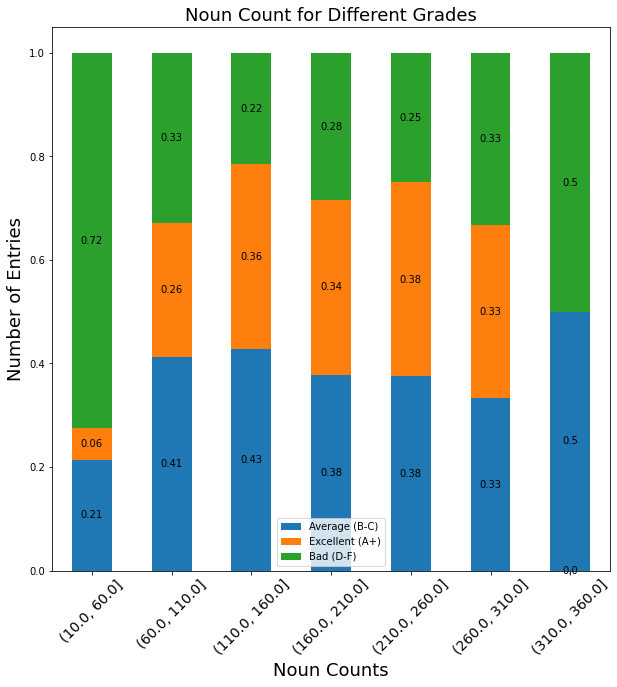

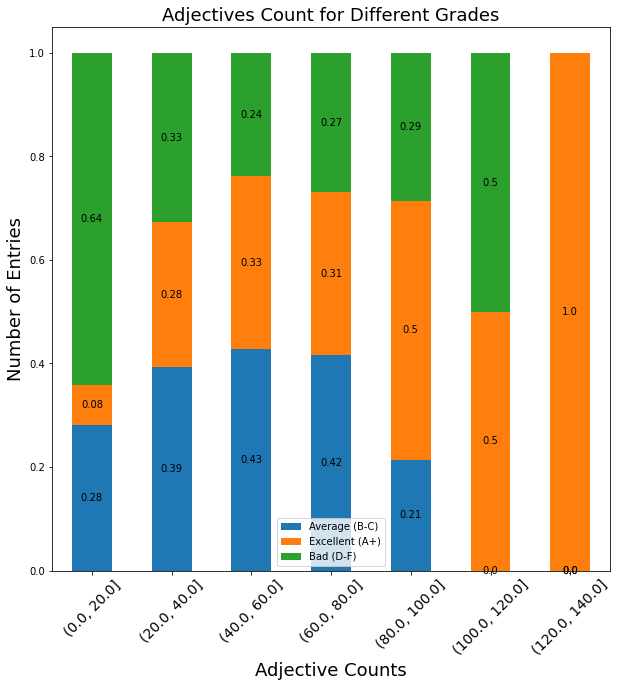

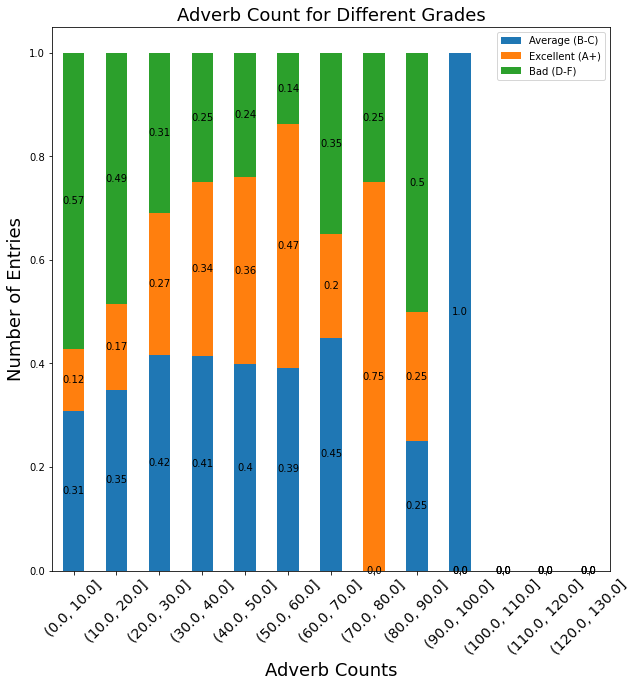

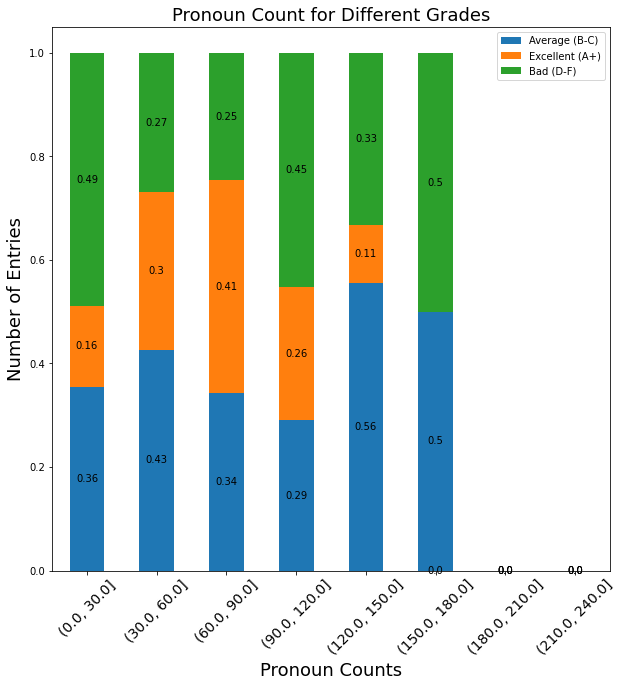

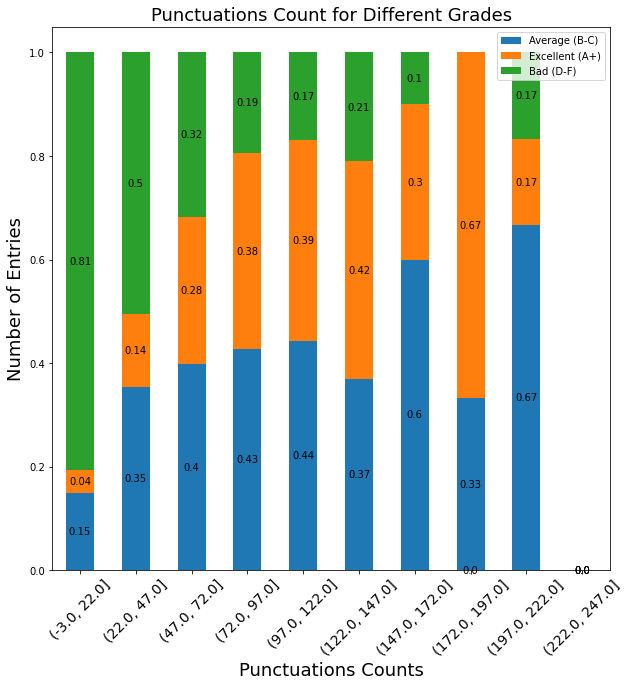

In [321]:
def display_stack_bar(col1,col2,title,xlabel,buffer,binsize):
  df_new = pd.DataFrame()
  bins_created = np.arange(min(df_essays[col1])-buffer, max(df_essays[col1]) + buffer, binsize) 
  df_essays[col2] = pd.cut(df_essays[col1], bins=bins_created)
  df_essays.sort_values(by = col1,inplace=True)
  counts = df_essays.groupby([col2,'Essay Grading'],sort=False).SentenceCount.count().unstack()
  df_essays.drop([col2], axis=1,inplace=True)
  counts.replace(np.nan,0,inplace=True)
  counts["sum"] = counts.sum(axis=1)
  df_new['Average (B-C)'] = counts['Average (B-C)']/counts['sum']
  df_new['Excellent (A+)'] = counts['Excellent (A+)']/counts['sum']
  df_new['Bad (D-F)'] = counts['Bad (D-F)']/counts['sum']
  ax = df_new.plot.bar(stacked=True,figsize=(10,10),width = 0.5)
  for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            round(height,2), 
            horizontalalignment='center', 
            verticalalignment='center')  
  plt.title(title,fontsize=18)
  plt.xlabel(xlabel,fontsize=18)
  plt.xticks(fontsize=14,rotation=45)
  plt.ylabel('Number of Entries',fontsize=18)
  plt.show()	

display_stack_bar('SentenceCount','SentenceCountCategory','Sentence Count for Different Grades','Sentence Counts',4,20)
display_stack_bar('WordCount','WordCountCategory','Word Count for Different Grades','Word Counts',30,100)
display_stack_bar('VerbCount','VerbCountCategory','Verb Count for Different Grades','Verb Counts',10,30)
display_stack_bar('NounCount','NounCountCategory','Noun Count for Different Grades','Noun Counts',10,50)
display_stack_bar('AdjCount','AdjectivesCountCategory','Adjectives Count for Different Grades','Adjective Counts',5,20)
display_stack_bar('AdverbCount','AdverbCountCategory','Adverb Count for Different Grades','Adverb Counts',2,10)
display_stack_bar('PronounCount','PronounCountCategory','Pronoun Count for Different Grades','Pronoun Counts',1,30)
display_stack_bar('PunctCount','PunctCountCategory','Punctuations Count for Different Grades','Punctuations Counts',10,25)

# **Calculating VERB/NOUN/ADJ.... density**

In [322]:
df_essays.tail()

,Essay Text,Essay Grading,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount
303,An early influence on my worldview was my fath...,Excellent (A+),63,1443,157.0,393.0,140.0,40.0,53.0,213.0
448,Confusion and panic were clearly visible. Peop...,Average (B-C),109,1436,204.0,222.0,64.0,61.0,138.0,216.0
411,Confusion and panic were clearly visible. Peop...,Average (B-C),109,1436,204.0,222.0,64.0,61.0,138.0,216.0
693,"“Lower your lids!” Gilad, my drama instructor,...",Average (B-C),92,1450,207.0,261.0,89.0,63.0,114.0,221.0
589,I wonder sometimes if any author’s story is qu...,Excellent (A+),115,2043,273.0,285.0,94.0,136.0,260.0,256.0


In [325]:
df_essays['VerbCount']  = df_essays.apply(lambda x: count_feature('VERB',x['Essay Text'], x['WordCount'],2), axis=1)
df_essays['NounCount']  = df_essays.apply(lambda x: count_feature('NOUN',x['Essay Text'], x['WordCount'],2), axis=1)
df_essays['AdjCount']  = df_essays.apply(lambda x: count_feature('ADJ',x['Essay Text'], x['WordCount'],2), axis=1)
df_essays['AdverbCount']  = df_essays.apply(lambda x: count_feature('ADV',x['Essay Text'], x['WordCount'],2), axis=1)
df_essays['PronounCount']  = df_essays.apply(lambda x: count_feature('PRON',x['Essay Text'], x['WordCount'],2), axis=1)
df_essays['PunctCount']  = df_essays.apply(lambda x: count_feature('PUNCT',x['Essay Text'], x['WordCount'],2), axis=1)

In [326]:
df_essays.tail()

,Essay Text,Essay Grading,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount
303,An early influence on my worldview was my fath...,Excellent (A+),63,1443,0.11,0.27,0.10,0.03,0.04,0.15
448,Confusion and panic were clearly visible. Peop...,Average (B-C),109,1436,0.14,0.15,0.04,0.04,0.10,0.15
411,Confusion and panic were clearly visible. Peop...,Average (B-C),109,1436,0.14,0.15,0.04,0.04,0.10,0.15
693,"“Lower your lids!” Gilad, my drama instructor,...",Average (B-C),92,1450,0.14,0.18,0.06,0.04,0.08,0.15
589,I wonder sometimes if any author’s story is qu...,Excellent (A+),115,2043,0.13,0.14,0.05,0.07,0.13,0.13


# **Let's visualize the dataset for normalization (w/o normalization)**

[  0  20  40  60  80 100]


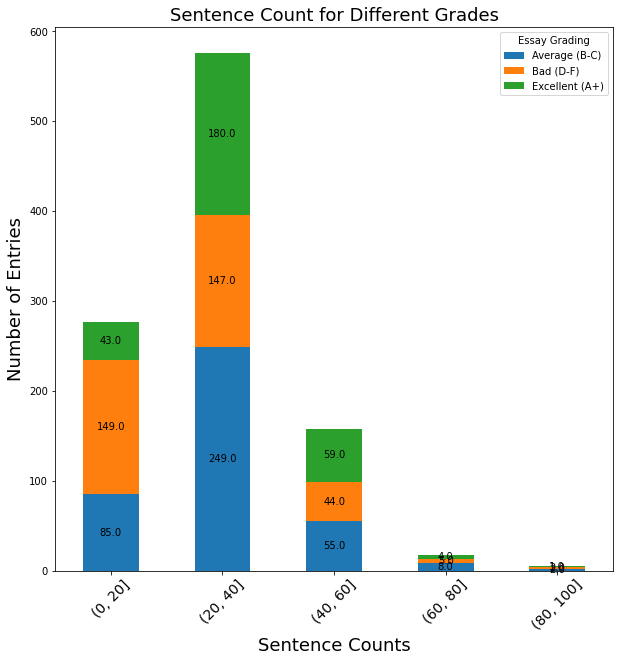

[  81  181  281  381  481  581  681  781  881  981 1081 1181 1281 1381
 1481 1581 1681 1781 1881 1981]


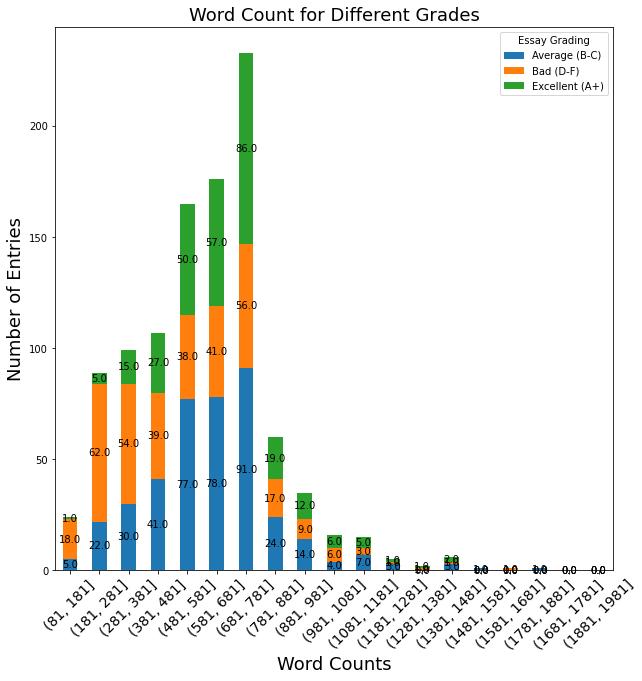

[0.06 0.11 0.16]


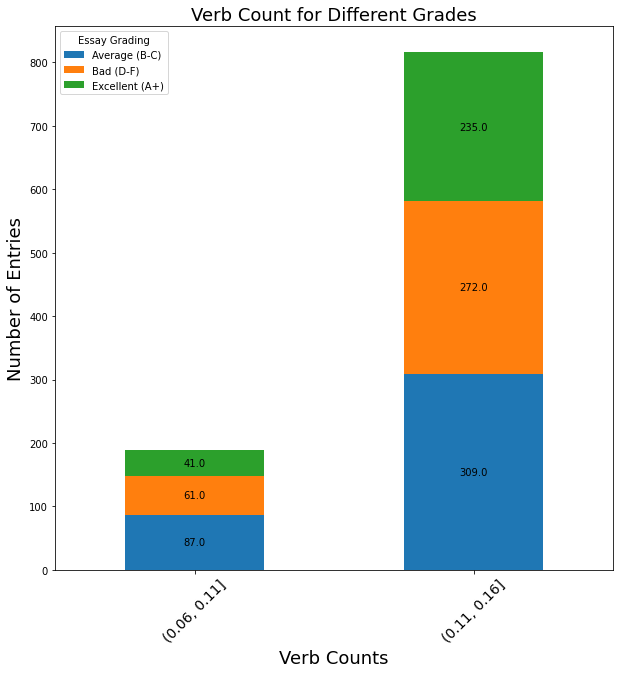

In [327]:
def display_stack_bar(col1,col2,title,xlabel,buffer,binsize):
  bins_created = np.arange(min(df_essays[col1])-buffer, max(df_essays[col1]) + buffer, binsize) 
  print(bins_created)
  df_essays[col2] = pd.cut(df_essays[col1], bins=bins_created)
  df_essays.sort_values(by = col1,inplace=True)
  counts = df_essays.groupby([col2,'Essay Grading'],sort=False).SentenceCount.count().unstack()
  df_essays.drop([col2], axis=1,inplace=True)
  counts.replace(np.nan,0,inplace=True)
  ax = counts.plot.bar(stacked=True,figsize=(10,10),width = 0.5)
  for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            round(height,2), 
            horizontalalignment='center', 
            verticalalignment='center')  
  plt.title(title,fontsize=18)
  plt.xlabel(xlabel,fontsize=18)
  plt.xticks(fontsize=14,rotation=45)
  plt.ylabel('Number of Entries',fontsize=18)
  plt.show()	

display_stack_bar('SentenceCount','SentenceCountCategory','Sentence Count for Different Grades','Sentence Counts',4,20)
display_stack_bar('WordCount','WordCountCategory','Word Count for Different Grades','Word Counts',30,100)
display_stack_bar('VerbCount','VerbCountCategory','Verb Count for Different Grades','Verb Counts',0,.05)
# display_stack_bar('NounCount','NounCountCategory','Noun Count for Different Grades','Noun Counts',10,50)
# display_stack_bar('AdjCount','AdjectivesCountCategory','Adjectives Count for Different Grades','Adjective Counts',5,20)
# display_stack_bar('AdverbCount','AdverbCountCategory','Adverb Count for Different Grades','Adverb Counts',2,10)
# display_stack_bar('PronounCount','PronounCountCategory','Pronoun Count for Different Grades','Pronoun Counts',1,30)
# display_stack_bar('PunctCount','PunctCountCategory','Punctuations Count for Different Grades','Punctuations Counts',10,25)

# **Scatter Plot**

In [328]:
dict  = {2:'Excellent (A+)',1:'Average (B-C)',0:'Bad (D-F)'}
# Split the data into features and target label

df_essays_copy = df_essays.copy()

df_essays_copy['Essay Grading'] = df_essays_copy['Essay Grading'].apply(lambda x:2 if x=="Excellent (A+)" else 1 if x=='Average (B-C)' else 0)
df_essays_copy.drop(['Essay Text'], axis = 1,inplace=True,errors='ignore')
data = np.asarray(df_essays_copy)

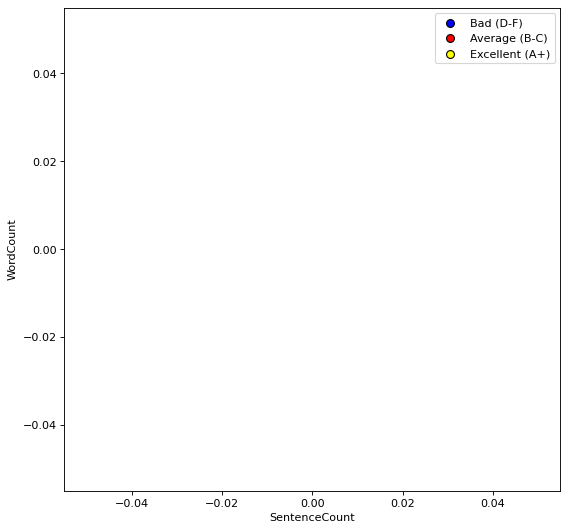

In [329]:
X = data[:,0:2] # SentenceCount WordCount
y = data[:,-1]

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.xlabel('SentenceCount')
plt.ylabel('WordCount')
plt.legend()
plt.show()

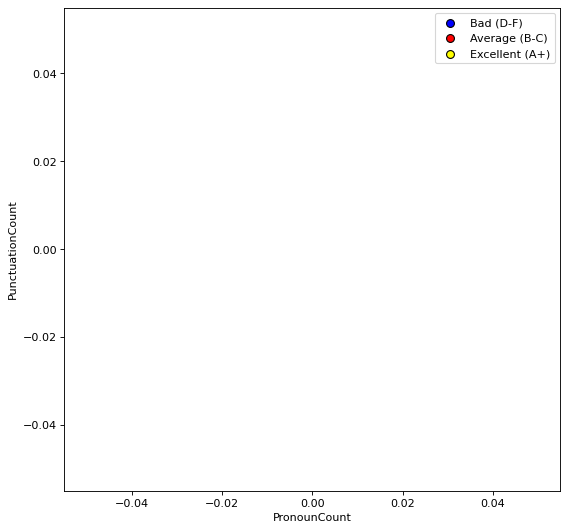

In [225]:
X = data[:,6:8] # PronounCount PunctCount
y = data[:,-1]

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.xlabel('PronounCount')
plt.ylabel('PunctuationCount')
plt.legend()
plt.show()

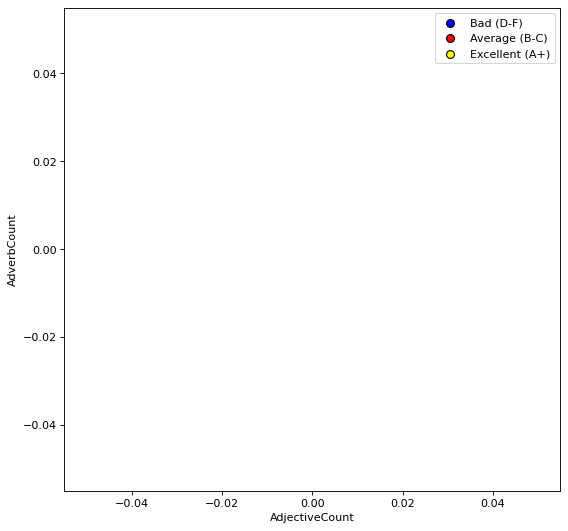

In [226]:
X = data[:,4:6] # Adjective AdverbCount
y = data[:,-1]

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.xlabel('AdjectiveCount')
plt.ylabel('AdverbCount')
plt.legend()
plt.show()


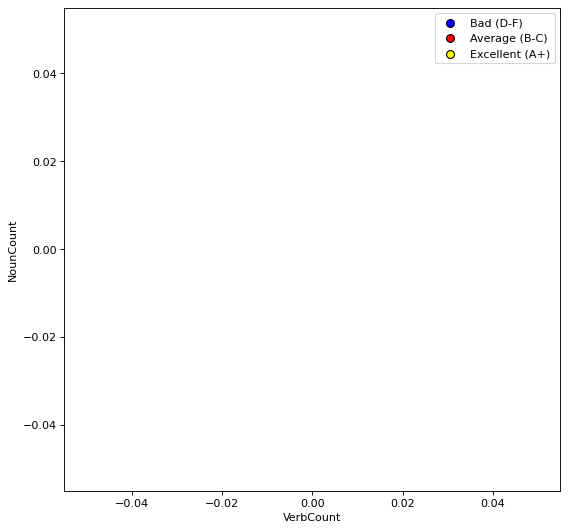

In [227]:
X = data[:,2:4] # VerbCount NounCount
y = data[:,-1]

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.xlabel('VerbCount')
plt.ylabel('NounCount')
plt.legend()
plt.show()

# **ROUGH WORK START**

In [228]:
df_essays.replace([np.inf, -np.inf], np.nan, inplace=True)

In [330]:
df_essays.isnull().sum()

Essay Text       0
Essay Grading    0
SentenceCount    0
WordCount        0
VerbCount        0
NounCount        0
AdjCount         0
AdverbCount      0
PronounCount     0
PunctCount       0
dtype: int64

In [230]:
df_essays.dropna(inplace=True)


In [231]:
df_essays.isnull().sum()

Essay Text       0
Essay Grading    0
SentenceCount    0
WordCount        0
VerbCount        0
NounCount        0
AdjCount         0
AdverbCount      0
PronounCount     0
PunctCount       0
dtype: int64

In [232]:
df_essays.head()

,Essay Text,Essay Grading,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount
495,The provided line graph depicts the marriages ...,Average (B-C),10,133,0.10,0.33,0.12,0.10,0.02,0.15
500,The pie chart illustrates the main causes of l...,Average (B-C),8,154,0.11,0.42,0.10,0.08,0.01,0.23
132,My most recent work experience at B Ltd was by...,Bad (D-F),6,142,0.12,0.39,0.13,0.05,0.04,0.14
501,The line graph represented how many units of e...,Average (B-C),6,130,0.12,0.36,0.08,0.05,0.02,0.15
177,"Though a landlocked nation, Nepal possesses a ...",Bad (D-F),10,173,0.13,0.37,0.24,0.05,0.03,0.16


# **ROUGH WORK END**

# **Active/Passive Voice Feature**

In [331]:
matcher = Matcher(nlp.vocab)

# function to check the type of sentence
def checkForSentType(inputEssay):  
    # running the model on sentence
    doc = nlp(inputEssay)
    sents = list(doc.sents)

    passive_rule = [{'DEP':'nsubjpass'},{'DEP':'aux','OP':'*'},{'DEP':'auxpass'},{'TAG':'VBN'}]
    matcher.add('Passive',None,passive_rule)
    matches = matcher(doc)
    #return (len(matches)/len(sents),(len(sents)-len(matches))/len(sents))
    return ((len(sents)-len(matches))/len(sents))

#df_essays[['NumberofPassiveVoice','NumberofActiveVoice']] = df_essays.apply(lambda row: pd.Series(checkForSentType(row['Essay Text'])),axis=1) 
df_essays['NumberofActiveVoice'] = df_essays.apply(lambda row: pd.Series(checkForSentType(row['Essay Text'])),axis=1) 

df_essays.reset_index(drop=True,inplace=True)

# **Complex, Compound Complex,Compound,Simple sentences Feature**

In [332]:
def getCountTypeSent(essay_text):
  complex_comp_list=[]
  complex_list=[]
  compound_list=[]
  simple_list=[]
  dep_list = []
  docu = nlp(essay_text)
  num_sent = len([sent for sent in docu.sents]) # Counting the number of sentences

  for sents in docu.sents:
    for token in sents:# Tokenize the sentence into words/tokens
      #subtree argument gives the subtree of the token when parsed in dependency parsing.
      subtree = token.subtree
      #Looking at the ancestors of a token can tell us how deep it is
      k = list(token.ancestors)
      #we need to add this to make the indexing work properly
      k.append('added_to_get_proper_indexing')
      #k=2 gives us the first level of the tree, k=3 will give us the next level.
      if(len(k)==2):
        #print([(t.text) for t in subtree], token.dep_)
        dep_list.append(token.dep_)
      #we missed the root phrase in the previous 
      if(token.dep_=='ROOT'):
        k =[token.text]
      #print(k, 'root')

    #complex sentences have (advcl) in their dependency tree
    #compound sentences have (cc)-> coordination and (conj)-> conjuction in their dependency tree
    #compound complex sentences have both the above
    #simple sentences have neither.
    if ('advcl') in dep_list and ('cc') in dep_list and ('conj') in dep_list:
      complex_comp_list.append('Complex-compound sentence')
    elif ('advcl') in dep_list:
      complex_list.append('Complex sentence')
    elif ('cc') in dep_list and ('conj') in dep_list:
      compound_list.append('Compound sentence')
    else:
      simple_list.append('Simple sentence')
  return (len(complex_comp_list)/num_sent,len(complex_list)/num_sent,len(compound_list)/num_sent,len(simple_list)/num_sent)
  
df_essays[['NumComplexComp','NumComplex','NumCompund','NumSimple']] = df_essays.apply(lambda row: pd.Series(getCountTypeSent(row['Essay Text'])),axis=1) 

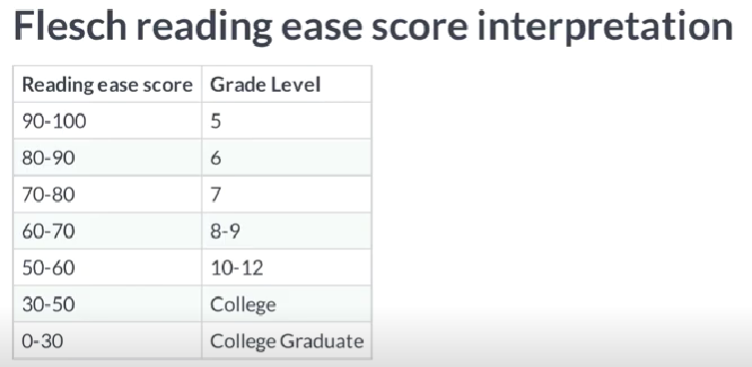

In [333]:
!pip install textatistic
def get_flesch_score(essay_text):
  readability_score = Textatistic(essay_text).scores
  return round(readability_score['flesch_score'],2)

df_essays['FleschScore'] = df_essays.apply(lambda x: get_flesch_score(x['Essay Text']),axis=1) 

In [338]:
df_essays.head(30)

,Essay Text,Essay Grading,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount,NumberofActiveVoice,NumComplexComp,NumComplex,NumCompund,NumSimple,FleschScore,UniqWordDensity
0,The provided line graph depicts the marriages ...,Average (B-C),10,227,0.06,0.19,0.07,0.06,0.01,0.09,1.000000,0.100000,0.800000,0.000000,0.100000,74.66,0.361233
1,The pie chart illustrates the main causes of l...,Average (B-C),8,247,0.07,0.26,0.06,0.05,0.01,0.14,1.000000,0.250000,0.125000,0.000000,0.625000,53.25,0.396761
2,"Though a landlocked nation, Nepal possesses a ...",Bad (D-F),10,270,0.08,0.24,0.15,0.03,0.02,0.10,0.900000,0.000000,1.000000,0.000000,0.000000,28.67,0.629630
3,The line graph represented how many units of e...,Average (B-C),6,200,0.08,0.23,0.06,0.04,0.01,0.10,0.833333,0.000000,0.666667,0.000000,0.333333,56.16,0.460000
4,"Throughout my high school career, I have recei...",Average (B-C),10,252,0.08,0.19,0.06,0.03,0.07,0.10,0.800000,0.100000,0.000000,0.000000,0.900000,51.76,0.559524
5,"I may seem to be a little bit unexpected, a ta...",Excellent (A+),18,570,0.08,0.17,0.08,0.06,0.05,0.13,1.000000,0.833333,0.166667,0.000000,0.000000,48.10,0.531579
6,My most recent work experience at B Ltd was by...,Bad (D-F),6,222,0.08,0.25,0.09,0.03,0.02,0.09,1.000000,0.000000,0.833333,0.000000,0.166667,18.72,0.639640
7,The community of honor guard members in Taiwan...,Bad (D-F),11,281,0.08,0.22,0.08,0.06,0.09,0.10,1.000000,0.000000,0.818182,0.000000,0.181818,75.48,0.462633
8,"Physical sciences, particularly physics cosmol...",Bad (D-F),22,438,0.09,0.18,0.08,0.08,0.06,0.09,1.000000,0.000000,0.954545,0.000000,0.045455,61.15,0.527397
9,The line graph illustrates the guests of four ...,Average (B-C),9,175,0.09,0.22,0.09,0.04,0.01,0.10,1.000000,0.000000,0.666667,0.000000,0.333333,74.97,0.502857


## **Number of 'Unique Words' Feature**

In [335]:
#stop_words = set(stopwords.words('english'))

nlp = spacy.load("en_core_web_sm")


def non_stop_words(essay):
  word_tokens = word_tokenize(essay)
  #filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  filtered_sentence = [w for w in word_tokens]
  str = ' '.join(filtered_sentence)
  mylist = re.findall(r'[^!?.,-;]+',str) # To remove punctuations
  str = ''.join(mylist)
  return str,len(filtered_sentence)

def word_count(essay):
  out = []
  seen = set()
  string,length = non_stop_words(essay)
  # print(essay)
  # print()
  # print(string)
  # print()
  # print(length)
  # print()
  doc = nlp(string)
  for word in doc:
    if word.text not in seen:
      if word.text != ' ':
        out.append(word)
        seen.add(word.text)
  #print(len(seen))
  return (len(seen)/length)   # Unique words density
  #return (len(seen))   # Unique words set


df_essays['UniqWordDensity']  = df_essays.apply(lambda x: word_count(x['Essay Text']), axis=1)

In [238]:
df_essays.head()
#print(df_test['Essay Text'].values)

,Essay Text,Essay Grading,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount,NumberofPassiveVoice,NumberofActiveVoice,NumComplexComp,NumComplex,NumCompund,NumSimple,FleschScore,UniqWordDensity
0,The provided line graph depicts the marriages ...,Average (B-C),10,133,0.10,0.33,0.12,0.10,0.02,0.15,0.000000,1.000000,0.10,0.800000,0.0,0.100000,74.66,0.436090
1,The pie chart illustrates the main causes of l...,Average (B-C),8,154,0.11,0.42,0.10,0.08,0.01,0.23,0.000000,1.000000,0.25,0.125000,0.0,0.625000,53.25,0.428571
2,My most recent work experience at B Ltd was by...,Bad (D-F),6,142,0.12,0.39,0.13,0.05,0.04,0.14,0.000000,1.000000,0.00,0.833333,0.0,0.166667,18.72,0.753521
3,The line graph represented how many units of e...,Average (B-C),6,130,0.12,0.36,0.08,0.05,0.02,0.15,0.166667,0.833333,0.00,0.666667,0.0,0.333333,56.16,0.515385
4,"Though a landlocked nation, Nepal possesses a ...",Bad (D-F),10,173,0.13,0.37,0.24,0.05,0.03,0.16,0.100000,0.900000,0.00,1.000000,0.0,0.000000,28.67,0.786127


In [337]:
df_essays.head()

,Essay Text,Essay Grading,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount,NumberofActiveVoice,NumComplexComp,NumComplex,NumCompund,NumSimple,FleschScore,UniqWordDensity
0,The provided line graph depicts the marriages ...,Average (B-C),10,227,0.06,0.19,0.07,0.06,0.01,0.09,1.000000,0.10,0.800000,0.0,0.100000,74.66,0.361233
1,The pie chart illustrates the main causes of l...,Average (B-C),8,247,0.07,0.26,0.06,0.05,0.01,0.14,1.000000,0.25,0.125000,0.0,0.625000,53.25,0.396761
2,"Though a landlocked nation, Nepal possesses a ...",Bad (D-F),10,270,0.08,0.24,0.15,0.03,0.02,0.10,0.900000,0.00,1.000000,0.0,0.000000,28.67,0.629630
3,The line graph represented how many units of e...,Average (B-C),6,200,0.08,0.23,0.06,0.04,0.01,0.10,0.833333,0.00,0.666667,0.0,0.333333,56.16,0.460000
4,"Throughout my high school career, I have recei...",Average (B-C),10,252,0.08,0.19,0.06,0.03,0.07,0.10,0.800000,0.10,0.000000,0.0,0.900000,51.76,0.559524


## **Using TfIdf Vectorizer**

###Spacy use is limited to 'Text Preprocessing' but not into 'Vectorization' or training.

### Next level of sophistication can be built by converting each word in the mail into its numerical value. We call this a 'word vectors'.

## **Technique**:
### An "*inverse document frequency factor*" is incorporated, which diminishes the weight of terms that occur very frequently in the document set and 	       increases the weight of the terms that occur rarely.

### This technique is implemented using **TfIdf Vectorizer** which also creates a 'DTM' matrix . However, instead of filling up the DTM with the 'token counts' , it calculates 'term frequency inverse document 	frequency' value for each word (TF-IDF).

In [339]:
# Split the data into features and target label
y = df_essays['Essay Grading']
X = df_essays['Essay Text']

y = y.apply(lambda x:2 if x=="Excellent (A+)" else 1 if x=='Average (B-C)' else 0)


# Import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

# Naïve Bayes:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])
text_clf_nb.fit(X_train, y_train)

y_train_pred = text_clf_nb.predict(X_train)
y_test_pred = text_clf_nb.predict(X_test)

# # Calculate the accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)
print('F1 score: ', format(f1_score(y_test,y_test_pred,average='micro')))
confusion_matrix(y_test, y_test_pred)

Training set has 828 samples.
Testing set has 208 samples.
The training accuracy is 0.6473429951690821
The test accuracy is 0.4230769230769231
F1 score:  0.4230769230769231


array([[18, 44,  0],
       [ 5, 70,  0],
       [ 2, 69,  0]])

## Below, We will not use **'TfIdfVectorizer'** but will use the features engineered above to do training and predictions.

In [357]:
# Split the data into features and target label
y = df_essays['Essay Grading']
X = df_essays.drop(['Essay Grading','Essay Text'], axis = 1)

y = y.apply(lambda x:2 if x=="Excellent (A+)" else 1 if x=='Average (B-C)' else 0)

# Import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

model = SVC(kernel='rbf', gamma=1,random_state = 39,probability=True)
model.fit(X_train, y_train)
# # Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)
print('F1 score: ', format(f1_score(y_test,y_test_pred,average='micro')))
confusion_matrix(y_test, y_test_pred)

Training set has 828 samples.
Testing set has 208 samples.
The training accuracy is 0.9927536231884058
The test accuracy is 0.36538461538461536
F1 score:  0.3653846153846153


array([[ 0, 62,  0],
       [ 1, 72,  2],
       [ 0, 67,  4]])

In [341]:
X_train.head()

,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount,NumberofActiveVoice,NumComplexComp,NumComplex,NumCompund,NumSimple,FleschScore,UniqWordDensity
658,36,729,0.14,0.22,0.07,0.05,0.05,0.11,0.972222,0.944444,0.000000,0.027778,0.027778,69.98,0.448560
704,18,342,0.14,0.22,0.10,0.08,0.04,0.11,0.888889,0.888889,0.055556,0.000000,0.055556,69.45,0.514620
954,23,507,0.16,0.20,0.05,0.04,0.08,0.12,0.913043,0.695652,0.173913,0.000000,0.130435,61.87,0.502959
800,26,715,0.14,0.19,0.05,0.03,0.09,0.08,1.000000,0.884615,0.076923,0.000000,0.038462,69.66,0.469930
39,23,558,0.10,0.21,0.08,0.06,0.08,0.11,0.956522,0.478261,0.434783,0.000000,0.086957,67.09,0.494624


In [342]:
y.value_counts()

1    401
0    347
2    288
Name: Essay Grading, dtype: int64

In [255]:
y.head()

0    1
1    1
2    0
3    1
4    0
Name: Essay Grading, dtype: int64

In [ ]:
# # Split the data into features and target label
# y = df_essays['Essay Grading']
# X = df_essays.drop(['Essay Grading','Essay Text'], axis = 1)

# y = y.apply(lambda x:2 if x=="Excellent (A+)" else 1 if x=='Average (B-C)' else 0)
# X.head()

In [ ]:
# # Import train_test_split

# # Split the 'features' and 'income' data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     y, 
#                                                     test_size = 0.3, 
#                                                     random_state = 0)

# # Show the results of the split
# print("Training set has {} samples.".format(X_train.shape[0]))
# print("Testing set has {} samples.".format(X_test.shape[0]))

In [354]:
# model = SVC(kernel='rbf', gamma=10,random_state = 39,probability=True)
# model.fit(X_train, y_train)
# # Making predictions
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# # Calculate the accuracy
# train_accuracy = accuracy_score(y_train, y_train_pred)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print('The training accuracy is', train_accuracy)
# print('The test accuracy is', test_accuracy)
# print('F1 score: ', format(f1_score(y_test,y_test_pred,average='micro')))
# confusion_matrix(y_test, y_test_pred)

The training accuracy is 0.993103448275862
The test accuracy is 0.35691318327974275
F1 score:  0.3569131832797428


array([[  0, 109,   0],
       [  0, 108,   1],
       [  0,  90,   3]])

In [344]:
# # model = SVC(kernel='', gamma=10,random_state = 39,probability=True)
# # model.fit(X_train, y_train)
# # #results = model.predict_proba(X_test)[0]
# # #print(model.predict_proba(X_test)[:, 1])
# # predictions_test = model.predict(X_test)


# #  #gets a dictionary of {'class_name': probability}
# # #prob_per_class_dictionary = dict(zip(model.classes_, results))

# # # gets a list of ['most_probable_class', 'second_most_probable_class', ..., 'least_class']
# # #results_ordered_by_probability = map(lambda x: x[0], sorted(zip(model.classes_, results), key=lambda x: x[1], reverse=True))
# # #print(list(results_ordered_by_probability))
# # print(accuracy_score(y_test,predictions_test))
# naive_bayes = MultinomialNB()
# naive_bayes.fit(X_train, y_train)
# predictions = naive_bayes.predict(X_test)

# print('Accuracy score: ', format(accuracy_score(y_test,predictions)))
# print('Precision score: ', format(precision_score(y_test,predictions,average='micro')))
# print('Recall score: ', format(recall_score(y_test,predictions,average='micro')))
# print('F1 score: ', format(f1_score(y_test,predictions,average='micro')))

Accuracy score:  0.40514469453376206
Precision score:  0.40514469453376206
Recall score:  0.40514469453376206
F1 score:  0.40514469453376206


In [ ]:
# from sklearn.linear_model import LogisticRegression

# lr= LogisticRegression(solver='lbfgs', random_state=0,max_iter =1000)
# lr.fit(X_train, y_train)
# y_pred_prob = lr.predict_proba(X_test)
# print(y_pred_prob.shape)
# labels = np.argmax(y_pred_prob, axis=0)
# # print(labels.shape)
# # print(labels)
# # print(lr.classes_)
# # print([y_pred_prob[i] for i in labels])
# y_pred_prob[125]

In [358]:

# lr= LogisticRegression(solver='lbfgs', random_state=0,max_iter =1000)
# lr.fit(X_train, y_train)
# y_pred_prob = lr.predict_proba(X_test)
# y_pred_prob
# # labels = np.argmax(y_pred_prob, axis=0)
# classes = lr.classes_
# print(classes)
# # labels = [classes[i] for i in labels]
# # print(accuracy_score(y_test, labels))
# # #x = y_pred_prob[0].argmax().item()
# # # ix
# # #y_pred_prob_test[0][ix]
# # # list = []
# # # list.append(y_pred_prob_test[0][ix])
# # # list.append(f'{y_pred_prob_test[0,ix]:.2%}')
# # # list

[0 1 2]


In [361]:
# #model = LogisticRegression(solver='sag', random_state=0,max_iter =10000)
# model = LogisticRegression(solver='newton-cg', random_state=0,max_iter =10000)

# model.fit(X_train, y_train)
# predictions = model.predict(X_test)

# print('Accuracy score: ', format(accuracy_score(y_test,predictions)))
# print('Precision score: ', format(precision_score(y_test,predictions,average='micro')))
# print('Recall score: ', format(recall_score(y_test,predictions,average='micro')))
# print('F1 score: ', format(f1_score(y_test,predictions,average='micro')))

Accuracy score:  0.4326923076923077
Precision score:  0.4326923076923077
Recall score:  0.4326923076923077
F1 score:  0.4326923076923077


In [362]:
# # Import the classifier from sklearn
# from sklearn.tree import DecisionTreeClassifier

# # TODO: Define the classifier, and fit it to the data
# model = DecisionTreeClassifier()
# model.fit(X_train, y_train)
# # Making predictions
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# # Calculate the accuracy
# from sklearn.metrics import accuracy_score
# train_accuracy = accuracy_score(y_train, y_train_pred)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print('The training accuracy is', train_accuracy)
# print('The test accuracy is', test_accuracy)

The training accuracy is 0.9927536231884058
The test accuracy is 0.375


In [363]:
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
# BaggingClassifier = BaggingClassifier(n_estimators = 400)
# BaggingClassifier.fit(X_train, y_train)
# y_train_pred = BaggingClassifier.predict(X_train)
# y_test_pred = BaggingClassifier.predict(X_test)
# train_accuracy = accuracy_score(y_train, y_train_pred)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print('The training accuracy is', train_accuracy)
# print('The test accuracy is', test_accuracy)


The training accuracy is 0.9927536231884058
The test accuracy is 0.47115384615384615


In [374]:
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
# RfClassifier = RandomForestClassifier(n_estimators = 5000)
# RfClassifier.fit(X_train, y_train)
# y_train_pred = RfClassifier.predict(X_train)
# y_test_pred = RfClassifier.predict(X_test)
# train_accuracy = accuracy_score(y_train, y_train_pred)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print('The training accuracy is', train_accuracy)
# print('The test accuracy is', test_accuracy)


The training accuracy is 0.9927536231884058
The test accuracy is 0.46634615384615385


In [380]:
clf = RandomForestClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune.
parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}

def calculate_F1_Score(parameters):
    # TODO: Make an fbeta_score scoring object.
   # scorer = make_scorer(f1_score)

    # TODO: Perform grid search on the classifier using 'scorer' as the scoring method.
    grid_obj = GridSearchCV(clf, parameters, scoring='f1_macro')

    # TODO: Fit the grid search object to the training data and find the optimal parameters.
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator.
    best_clf = grid_fit.best_estimator_

    # Fit the new model.
    best_clf.fit(X_train, y_train)

    # Make predictions using the new model.
    best_train_predictions = best_clf.predict(X_train)
    best_test_predictions = best_clf.predict(X_test)

    best_train_predictions = best_clf.predict(X_train)
    best_test_predictions = best_clf.predict(X_test)

    y_pred_prob = best_clf.predict_proba(X_test)

    train_accuracy = accuracy_score(y_train, best_train_predictions)
    test_accuracy = accuracy_score(y_test, best_test_predictions)
    print('The training accuracy is', train_accuracy)
    print('The test accuracy is', test_accuracy)
    print(y_pred_prob)
#----------------------------------------------#

# Call the function
calculate_F1_Score(parameters)


The training accuracy is 0.717391304347826
The test accuracy is 0.5
[[0.35249078 0.38354272 0.2639665 ]
 [0.62684676 0.23453274 0.13862049]
 [0.24142502 0.40887184 0.34970314]
 [0.19501527 0.51913145 0.28585328]
 [0.18407706 0.48166598 0.33425697]
 [0.10383595 0.59607135 0.3000927 ]
 [0.33917709 0.46902146 0.19180145]
 [0.12090928 0.53923109 0.33985962]
 [0.54526792 0.26485295 0.18987913]
 [0.20833955 0.4525288  0.33913165]
 [0.55076464 0.32454133 0.12469403]
 [0.14728434 0.52693265 0.32578301]
 [0.22590593 0.41111154 0.36298253]
 [0.72085118 0.20061011 0.07853871]
 [0.54184055 0.32689654 0.13126291]
 [0.63030189 0.29824103 0.07145708]
 [0.14683846 0.45753395 0.39562758]
 [0.67542954 0.23071993 0.09385052]
 [0.44919222 0.41480333 0.13600445]
 [0.41796624 0.47309466 0.1089391 ]
 [0.14484191 0.47161856 0.38353953]
 [0.2056477  0.4435203  0.350832  ]
 [0.25771885 0.40525334 0.33702781]
 [0.54135783 0.31450291 0.14413926]
 [0.25787403 0.47191863 0.27020734]
 [0.11308579 0.49606763 0.390846

In [252]:
# # df_test = df_essays[:5]
# df_essays['Essay Grading'].value_counts()

Average (B-C)     401
Bad (D-F)         347
Excellent (A+)    288
Name: Essay Grading, dtype: int64

In [253]:
# # df_essays.head()
# df_essays[df_essays['Essay Grading']=='Bad (D-F)'].tail()

,Essay Text,Essay Grading,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount,NumberofPassiveVoice,NumberofActiveVoice,NumComplexComp,NumComplex,NumCompund,NumSimple,FleschScore,UniqWordDensity
1029,"""Can you explain it again professor?"" I feel w...",Bad (D-F),13,135,0.33,0.32,0.07,0.12,0.27,0.17,0.076923,0.923077,0.923077,0.000000,0.000000,0.076923,78.33,0.674074
1031,My very first Kpop audition was for a company ...,Bad (D-F),14,111,0.33,0.26,0.09,0.16,0.19,0.17,0.000000,1.000000,0.857143,0.000000,0.071429,0.071429,83.42,0.720721
1033,Please check for grammatical mistakes and even...,Bad (D-F),38,361,0.35,0.35,0.07,0.10,0.27,0.12,0.052632,0.947368,0.973684,0.000000,0.026316,0.000000,76.28,0.584488
1034,The last race for the cross country team was a...,Bad (D-F),31,239,0.35,0.28,0.11,0.10,0.23,0.16,0.000000,1.000000,0.806452,0.129032,0.000000,0.064516,81.93,0.656904
1035,I was walking out of a company with a smile on...,Bad (D-F),36,429,0.35,0.31,0.11,0.08,0.26,0.13,0.055556,0.944444,0.916667,0.083333,0.000000,0.000000,57.79,0.582751


# **Plotting Passive Voice & Active voice against number of sentences**#

In [260]:
df_essays[df_essays['Essay Grading']=='Average (B-C)']

,Essay Text,Essay Grading,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount,NumberofPassiveVoice,NumberofActiveVoice,NumComplexComp,NumComplex,NumCompund,NumSimple,FleschScore,UniqWordDensity
0,The provided line graph depicts the marriages ...,Average (B-C),10,133,0.10,0.33,0.12,0.10,0.02,0.15,0.000000,1.000000,0.100000,0.800000,0.0,0.100000,74.66,0.436090
1,The pie chart illustrates the main causes of l...,Average (B-C),8,154,0.11,0.42,0.10,0.08,0.01,0.23,0.000000,1.000000,0.250000,0.125000,0.0,0.625000,53.25,0.428571
3,The line graph represented how many units of e...,Average (B-C),6,130,0.12,0.36,0.08,0.05,0.02,0.15,0.166667,0.833333,0.000000,0.666667,0.0,0.333333,56.16,0.515385
5,"1 \nEntrepreneur: In 1998, at the age of eight...",Average (B-C),32,441,0.14,0.33,0.14,0.07,0.06,0.21,0.031250,0.968750,0.781250,0.031250,0.0,0.187500,62.41,0.637188
7,"Throughout my high school career, I have recei...",Average (B-C),10,148,0.14,0.32,0.10,0.05,0.12,0.16,0.200000,0.800000,0.100000,0.000000,0.0,0.900000,51.76,0.702703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,MY FAMILY HAS TAKEN LIVING IN the big city as ...,Average (B-C),23,257,0.30,0.33,0.14,0.10,0.20,0.16,0.217391,0.782609,0.826087,0.000000,0.0,0.173913,71.79,0.696498
1011,I like talking to people. And I like to thrift...,Average (B-C),5,78,0.31,0.42,0.09,0.09,0.15,0.15,0.200000,0.800000,0.200000,0.000000,0.2,0.600000,55.73,0.846154
1013,"When I turned twelve, my stepdad turned violen...",Average (B-C),22,293,0.31,0.34,0.11,0.10,0.21,0.17,0.045455,0.954545,0.818182,0.181818,0.0,0.000000,75.31,0.682594
1022,I laugh when people say that they wonder about...,Average (B-C),29,293,0.32,0.24,0.13,0.13,0.25,0.24,0.206897,0.793103,0.827586,0.172414,0.0,0.000000,71.31,0.655290


In [324]:
print(df_essays.iloc[2]['Essay Text'])

I love mathematics, my whole life I've been involved in activities related to this subject. Through my participation in competitions I've been interested in the combinatorial problems and conferences offered by famous mathematicians like "The mathematics of Doodling" by Professor Ravi Vakil on the IMO Lecture. Talking with him and contestants from other countries I've found myself immersed in the maths world, which is why I'd love to be part of your Mathematics Department in applied combinatorics. I find very exciting how your UROP can help me to obtain experience and make contributions in the field before even graduating.


In [294]:
df_test = df_essays.iloc[[1035]]
def count_sentences(essay):
  doc = nlp(essay)
  for sent in doc.sents:
    print("This is the sentence")
    print(sent)
    print()
  # doc_sents = [sent for sent in doc.sents]
  # print(len(doc_sents))

df_test['SentenceCount'] = df_test['Essay Text'].apply(count_sentences)

This is the sentence
I was walking out of a company with a smile on my face, happiness in my heart and a voice inside my head saying "this is what you are and you finally did it".

This is the sentence
Before I explain you why I was so happy and satisfied

This is the sentence
let me start with an incident happened 2 months back.
 

This is the sentence
From 1 year I was working on my independent project to build a network system which cannot be hacked, I went to different companies to know the major issues they are facing with information security, and one day I came up with an idea to build a centralized network which acts like a brain which has no way to hack into.

This is the sentence
So I went to a company to meet the systems architect to confirm if the idea could work, he was surprised with the idea and said it will work if I can design the absolute network I explained.

This is the sentence
He gave me some of his research records and said if they could help, I returned home and

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [283]:
df_test.head

Essay Text       I was walking out of a company with a smile on...
Essay Grading                                            Bad (D-F)
SentenceCount                                                   36
WordCount                                                      429
VerbCount                                                     0.35
Name: 1035, dtype: object

In [279]:
df_essays.iloc[1035]

Essay Text              I was walking out of a company with a smile on...
Essay Grading                                                   Bad (D-F)
SentenceCount                                                          36
WordCount                                                             429
VerbCount                                                            0.35
NounCount                                                            0.31
AdjCount                                                             0.11
AdverbCount                                                          0.08
PronounCount                                                         0.26
PunctCount                                                           0.13
NumberofPassiveVoice                                            0.0555556
NumberofActiveVoice                                              0.944444
NumComplexComp                                                   0.916667
NumComplex                            

In [ ]:
dict  = {2:'Excellent (A+)',1:'Average (B-C)',0:'Bad (D-F)'}
# Split the data into features and target label

df_essays_copy = df_essays.copy()

df_essays_copy['Essay Grading'] = df_essays_copy['Essay Grading'].apply(lambda x:2 if x=="Excellent (A+)" else 1 if x=='Average (B-C)' else 0)
df_essays_copy.drop(['Essay Text'], axis = 1,inplace=True,errors='ignore')
data = np.asarray(df_essays_copy)

In [ ]:
X = data[:, [0, 9]] # SentenceCount,NumberofPassiveVoice
y = data[:,-3]

plt.figure(figsize=(18, 18), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.ylabel('Number of Passive Voice Sentences')
plt.xlabel('Number of Sentences')
plt.legend()
plt.show()


In [ ]:
X = data[:, [0, 10]] # SentenceCount,NumberofActiveVoice
y = data[:,-3]

plt.figure(figsize=(18, 18), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.ylabel('Number of Active Voice Sentences')
plt.xlabel('Number of Sentences')
plt.legend()
plt.show()


In [ ]:
X.head

In [ ]:
y.head()